In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import TACO_dataset_builder as tdb
import sys
import os
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './vision/references/detection')
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [3]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        #transforms.append(T.RandomHorizontalFlip(0.5))
        pass
    return T.Compose(transforms)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
dataset = tdb.builder('./TACO/',(400,400), get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
model.eval()
# For Training
'''images,targets = next(iter(data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

#output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]'''
#predictions = model(x.to(device))     
#predictions = model(x)     

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


'images,targets = next(iter(data_loader))\nimages = list(image.to(device) for image in images)\ntargets = [{k: v.to(device) for k, v in t.items()} for t in targets]\n\n#images = list(image for image in images)\ntargets = [{k: v for k, v in t.items()} for t in targets]\n\n#output = model(images,targets)   # Returns losses and detections\n# For inference\nmodel.eval()\nx = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]'

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load('./checkpoints/maskRCNNResNET50_2/0.pt')
model.eval()
model.to(device)

params = [p for p in model.parameters()]
print(len(params))

95


In [10]:
images,targets = next(iter(data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v for k, v in t.items()} for t in targets]

pred = None

with torch.no_grad():
    pred = model(images)

    for pr in pred:
        print(pr['boxes'])
        for label in pr['labels']:
            print(dataset.coco.cats[label.item()])
        print()

/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. P

tensor([[161.1326, 294.0632, 209.1865, 352.6409],
        [162.7509, 295.5046, 209.4567, 348.9124],
        [ 23.9001,  55.7090, 392.3054, 393.4076],
        [160.1266, 292.3860, 211.5554, 350.9447]], device='cuda:0')
{'supercategory': 'Plastic container', 'id': 44, 'name': 'Tupperware'}


KeyError: 77

In [7]:
targets[0]['masks'].shape

torch.Size([1, 400, 400])

torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


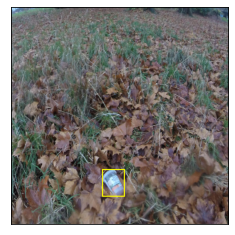

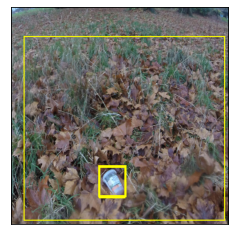

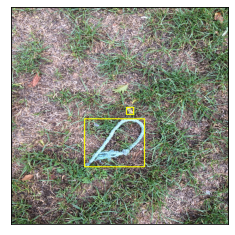

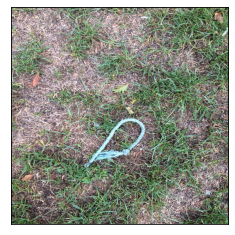

In [11]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms as T

path = './TACO/data/'
img_path = ''

for x in range(0,2):
    path = './TACO/data/'
    img_path = ''
    for (key, value) in dataset.imgMap.items():
        if value['image_id'] == targets[x]['image_id'][0].item():
            img_path = key
            break

    path = path + img_path
    img = read_image(path)
    img = T.Resize(size=(400,400))(img)
    boxes = targets[x]['boxes']
    mask = targets[x]['masks']
    pred_boxes = pred[x]['boxes']
    #pred_mask = pred[x]['masks']
    print(img.size())
    drawn_boxes = draw_bounding_boxes(img, boxes, width=2, colors="yellow")
    drawn_boxes_pred = draw_bounding_boxes(img, pred_boxes, width=2, colors="yellow")
    show(drawn_boxes)
    show(drawn_boxes_pred)

In [16]:
boxes.shape

torch.Size([4, 4])

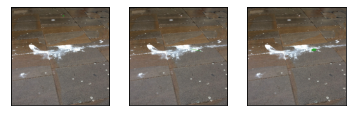

In [17]:
obj_ids = torch.unique(mask)
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]
#masks = T.Resize(size=(400,400))(masks)

drawn_masks = []
drawn_masks_pred = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="green"))

show(drawn_masks)

In [16]:
obj_ids = torch.unique(pred_mask)
obj_ids = obj_ids[1:]
masks = pred_mask == obj_ids[:, None, None]
drawn_masks = []
drawn_masks_pred = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="green"))

show(drawn_masks)

RuntimeError: CUDA out of memory. Tried to allocate 7.44 GiB (GPU 0; 6.00 GiB total capacity; 1000.11 MiB already allocated; 2.65 GiB free; 1.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

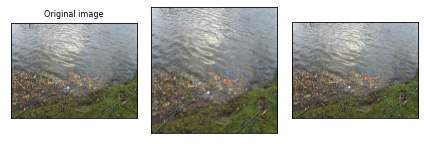

In [14]:
from PIL import Image
import torchvision.transforms as T
orig_img = Image.open(path)

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

resized_imgs = [T.Resize(size=size)(orig_img) for size in ((400,400), (2000, 2624))]
plot(resized_imgs)

In [9]:
orig_img.size

(2624, 1968)

In [9]:
# use our dataset and defined transformations
dataset = tdb.builder('./TACO/', (400,400), get_transform(train=True))
dataset_test = tdb.builder('./TACO/', (400,400), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 61 classes only - background and person
num_classes = 61

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [13]:
[p.requires_grad for p in model.parameters()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [21]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

checkpoint_path = './checkpoints/maskRCNNResNET50local'

for epoch in range(0,num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    print("Epoch completed : ",epoch)
    torch.save(model,checkpoint_path+"/"+str(epoch)+".pt")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },checkpoint_path+"/"+str(epoch)+"state_dict.pt")
    print("Model saved")
    print()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. P

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [23]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

NVMLError_Unknown: Unknown Error

In [22]:
import torch
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)

6442123264
3007315968
2821720064
185595904


In [29]:
torch.cuda.empty_cache()

In [ ]:
from torch.optim.lr_scheduler import StepLR


# use our dataset and defined transformations
dataset = tdb.builder('./TACO/', (400,400), get_transform(train=True))
dataset_test = tdb.builder('./TACO/', (400,400), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 61 classes only - background and person
num_classes = 61

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

loss_list = []
n_epochs = 10
model.train()
range_ = range(0, 10)
total = len(range_)
#with tqdm(total=total, position=0, leave=True) as pbar:
image_ids = []
checkpoint_path = './checkpoints/maskRCNNResNET50'
for epoch in tqdm(range(n_epochs)):
    print("Epoch : ",epoch)
    loss_epoch = []
    iteration = 1
    image_ids = []
    it = iter(data_loader)
    #for images,targets in next(it): #tqdm(data_loader):
    for i, (images, targets) in enumerate(data_loader):
        try:
            print("Batch No.: ",iteration)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            for x in range(0,2):
                image_id = targets[x]['image_id'][0].item()
                image_ids.append(image_id)
                #print("Image ID : ",targets[x]['image_id'][0].item())

            optimizer.zero_grad()
            #model=model.double()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()       
            optimizer.step()
            # print('loss:', losses.item())
            # loss_epoch.append(losses.item())
            loss_epoch.append(losses.item())

            iteration+=1
        except Exception as e: 
            print(e)
    loss_epoch_mean = np.mean(loss_epoch) 
    loss_list.append(loss_epoch_mean) 
    # loss_list.append(loss_epoch_mean)    
    print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))
    #save model state
    print("Epoch completed : ",epoch)
    torch.save(model,checkpoint_path+"/"+str(epoch)+".pt")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },checkpoint_path+"/"+str(epoch)+"state_dict.pt")
    print("Model saved")
    print()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  0


/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Batch No.:  1
Batch No.:  2
Batch No.:  3
Batch No.:  4
Batch No.:  5
Batch No.:  6
Batch No.:  7
Batch No.:  8
Batch No.:  9
Batch No.:  10
Batch No.:  11
Batch No.:  12
Batch No.:  13
Batch No.:  14
Batch No.:  15
Batch No.:  16
Batch No.:  17
Batch No.:  18
Batch No.:  19
Batch No.:  20
Batch No.:  21
Batch No.:  22
Batch No.:  23
Batch No.:  24
Batch No.:  25
Batch No.:  26
Batch No.:  27
Batch No.:  28
Batch No.:  29
Batch No.:  30
Batch No.:  31
Batch No.:  32
Batch No.:  33
Batch No.:  34
Batch No.:  35
Batch No.:  36
Batch No.:  37
Batch No.:  38
Batch No.:  39
Batch No.:  40
Batch No.:  41
Batch No.:  42
Batch No.:  43
Batch No.:  44
Batch No.:  45
Batch No.:  46
Batch No.:  47
Batch No.:  48
Batch No.:  49
Batch No.:  50
Batch No.:  51
Batch No.:  52
Batch No.:  53
Batch No.:  54
Batch No.:  55
Batch No.:  56
Batch No.:  57
Batch No.:  58
Batch No.:  59
Batch No.:  60
Batch No.:  61
Batch No.:  62
Batch No.:  63
Batch No.:  64
Batch No.:  65
Batch No.:  66
Batch No.:  67
Batc

In [10]:
loss_list = []
n_epochs = 10
model.train()
range_ = range(0, 10)
total = len(range_)
#with tqdm(total=total, position=0, leave=True) as pbar:
image_ids = []
checkpoint_path = './checkpoints/maskRCNNResNET50'
for epoch in tqdm(range(n_epochs)):
    print("Epoch : ",epoch)
    loss_epoch = []
    iteration = 1
    image_ids = []
    it = iter(data_loader)
    #for images,targets in next(it): #tqdm(data_loader):
    for i, (images, targets) in enumerate(data_loader):
        try:
            print("Batch No.: ",iteration)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            for x in range(0,2):
                image_id = targets[x]['image_id'][0].item()
                image_ids.append(image_id)
                #print("Image ID : ",targets[x]['image_id'][0].item())

            optimizer.zero_grad()
            #model=model.double()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()       
            optimizer.step()
            # print('loss:', losses.item())
            # loss_epoch.append(losses.item())
            loss_epoch.append(losses.item())
            
            iteration+=1
        except Exception as e: 
            print(e)
    loss_epoch_mean = np.mean(loss_epoch) 
    loss_list.append(loss_epoch_mean) 
    # loss_list.append(loss_epoch_mean)    
    print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))
    #save model state
    print("Epoch completed : ",epoch)
    torch.save(model,checkpoint_path+"/"+str(epoch)+".pt")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },checkpoint_path+"/"+str(epoch)+"state_dict.pt")
    print("Model saved")
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  0


/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/TACO_dataset_builder.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Batch No.:  1


/home/vader/sfu/spring22/cmpt733/Project/image-classfier-waste-sorting/733Project/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Batch No.:  2
Batch No.:  3
Batch No.:  4
Batch No.:  5
Batch No.:  6
Batch No.:  7
Batch No.:  8
Batch No.:  9
Batch No.:  10
Batch No.:  11
Batch No.:  12
Batch No.:  13
Batch No.:  14
Batch No.:  15
Batch No.:  16
Batch No.:  17
Batch No.:  18
Batch No.:  19
Batch No.:  20
Batch No.:  21
Batch No.:  22
Batch No.:  23
Batch No.:  24
Batch No.:  25
Batch No.:  26
Batch No.:  27
Batch No.:  28
Batch No.:  29
Batch No.:  30
Batch No.:  31
Batch No.:  32
Batch No.:  33
Batch No.:  34
Batch No.:  35
Batch No.:  36
Batch No.:  37
Batch No.:  38
Batch No.:  39
Batch No.:  40
Batch No.:  41
Batch No.:  42
Batch No.:  43
Batch No.:  44
Batch No.:  45
Batch No.:  46
Batch No.:  47
Batch No.:  48
Batch No.:  49
Batch No.:  50
Batch No.:  51
Batch No.:  52
Batch No.:  53
Batch No.:  54
Batch No.:  55
Batch No.:  56
Batch No.:  57
Batch No.:  58
Batch No.:  59
Batch No.:  60
Batch No.:  61
Batch No.:  62
Batch No.:  63
Batch No.:  64
Batch No.:  65
Batch No.:  66
Batch No.:  67
Batch No.:  68
Bat

Batch No.:  521
Batch No.:  522
Batch No.:  523
Batch No.:  524
Batch No.:  525
Batch No.:  526
Batch No.:  527
Batch No.:  528
Batch No.:  529
Batch No.:  530
Batch No.:  531
Batch No.:  532
Batch No.:  533
Batch No.:  534
Batch No.:  535
Batch No.:  536
Batch No.:  537
Batch No.:  538
Batch No.:  539
Batch No.:  540
Batch No.:  541
Batch No.:  542
Batch No.:  543


RuntimeError: DataLoader worker (pid(s) 34405) exited unexpectedly

In [11]:
image_ids

[1125,
 960,
 676,
 179,
 840,
 152,
 1233,
 912,
 1422,
 1357,
 1154,
 965,
 221,
 1007,
 1206,
 180,
 1133,
 701,
 1479,
 635,
 1343,
 1275,
 812,
 617,
 1130,
 731,
 798,
 1320,
 222,
 752,
 836,
 1239,
 909,
 790,
 601,
 281,
 1073,
 1262,
 1424,
 208,
 246,
 1315,
 215,
 314,
 1382,
 1253,
 977,
 1339,
 1094,
 104,
 444,
 1237,
 1060,
 395,
 290,
 548,
 976,
 468,
 55,
 1050,
 1288,
 645,
 1063,
 1215,
 466,
 473,
 1362,
 1069,
 419,
 865,
 881,
 407,
 1136,
 973,
 1438,
 1468,
 757,
 691,
 1413,
 340,
 1115,
 479,
 279,
 875,
 53,
 370,
 1011,
 1091,
 1195,
 238,
 710,
 69,
 1193,
 671,
 206,
 127,
 4,
 964,
 101,
 346,
 1004,
 612,
 87,
 1344,
 1126,
 517,
 864,
 95,
 1076,
 852,
 946,
 521,
 1093,
 534,
 83,
 576,
 16,
 1212,
 923,
 443,
 1471,
 503,
 586,
 494,
 1295,
 858,
 791,
 1210,
 785,
 573,
 1292,
 140,
 324,
 387,
 918,
 459,
 237,
 262,
 1379,
 526,
 1246,
 255,
 1299,
 955,
 1486,
 273,
 792,
 862,
 1477,
 688,
 518,
 1425,
 743,
 789,
 1458,
 1095,
 751,
 680,
 409

In [21]:
image_ids1

[3,
 4,
 9,
 13,
 15,
 17,
 18,
 23,
 27,
 31,
 41,
 43,
 47,
 49,
 51,
 52,
 54,
 55,
 63,
 64,
 66,
 70,
 76,
 78,
 82,
 83,
 88,
 91,
 94,
 100,
 102,
 104,
 110,
 112,
 116,
 126,
 129,
 135,
 138,
 140,
 143,
 144,
 153,
 160,
 162,
 164,
 166,
 167,
 169,
 173,
 177,
 181,
 182,
 183,
 192,
 193,
 196,
 211,
 218,
 222,
 223,
 225,
 234,
 237,
 240,
 242,
 254,
 262,
 263,
 267,
 273,
 274,
 278,
 279,
 281,
 287,
 295,
 298,
 299,
 300,
 302,
 309,
 312,
 316,
 317,
 321,
 324,
 332,
 334,
 335,
 336,
 343,
 347,
 354,
 356,
 362,
 368,
 369,
 370,
 372,
 375,
 376,
 380,
 381,
 386,
 388,
 397,
 400,
 401,
 404,
 407,
 412,
 414,
 417,
 420,
 432,
 433,
 436,
 440,
 442,
 448,
 449,
 450,
 452,
 458,
 460,
 462,
 467,
 469,
 472,
 479,
 483,
 490,
 492,
 494,
 506,
 508,
 512,
 513,
 527,
 528,
 541,
 550,
 552,
 555,
 556,
 558,
 567,
 573,
 574,
 577,
 580,
 582,
 583,
 586,
 587,
 595,
 598,
 605,
 607,
 610,
 611,
 612,
 614,
 621,
 625,
 632,
 635,
 636,
 637,
 642,
 645,
